In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


For the Mental Health Classification problem, data preprocessing and multiple model implementation were used. In the data processing step, different feature engineering is applied. Each section has comments on what processes are used in the code. After data processing, MinMax Scaling is applied to normalize the feature values within a specific range (e.g., [0, 1]), ensuring that all features contribute equally to the model and improving convergence during training. Various ensemble models, including CatBoost, XGBoost, Bagging with CatBoost, Bagging with XGBoost, and a Voting Classifier, were employed to leverage their strengths in handling complex datasets and improving predictive performance. CatBoost, known for its efficiency with categorical features and ability to minimize overfitting, achieved the best private score with an accuracy of 93.825%. XGBoost, recognized for its capability to handle large datasets while effectively reducing bias and variance, also performed well. Bagging was utilized to combine multiple models (e.g., CatBoost and XGBoost) to reduce variance further. The Voting Classifier, which aggregates predictions from multiple models to enhance overall accuracy by combining their diverse strengths, delivered the best public score with an accuracy of 94.083%. This ensemble approach enabled the identification of the most effective model for both public and private datasets.

# Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read Files

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')
df_sample = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')


In [4]:
df_train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


# Data Processing

In [5]:
# Function to map ages to specific age group ranges
def map_age_to_range(age):
    # If age is less than 20, categorize as 'Teen'
    if age < 20:
        return 'Teen'
    # If age is between 20 and 29 inclusive, categorize as 'Young Adult'
    elif 20 <= age < 30:
        return 'Young Adult'
    # If age is between 30 and 44 inclusive, categorize as 'Adult'
    elif 30 <= age < 45:
        return 'Adult'
    # If age is between 45 and 59 inclusive, categorize as 'Middle Age'
    elif 45 <= age < 60:
        return 'Middle Age'
    # If age is 60 or above, categorize as 'Senior'
    else:
        return 'Senior'

# Applying the mapping function to the Age column of the training dataset
df_train['Age_group'] = df_train['Age'].apply(map_age_to_range)

# Applying the mapping function to the Age column of the test dataset
df_test['Age_group'] = df_test['Age'].apply(map_age_to_range)

In [6]:
# Dropping the original 'Age' column from the training dataset
df_train = df_train.drop(columns=['Age'])

# Dropping the original 'Age' column from the test dataset
df_test = df_test.drop(columns=['Age'])

In [7]:
# Drop id and Name as they are not useful for the predictive task or analysis

# Dropping the 'id' column from the training dataset 
df_train = df_train.drop(columns=['id'])

# Dropping the 'id' column from the test dataset
df_test = df_test.drop(columns=['id'])

# Dropping the 'Name' column from the training dataset
df_train = df_train.drop(columns=['Name'])

# Dropping the 'Name' column from the test dataset
df_test = df_test.drop(columns=['Name'])

In [8]:
# Function to map 'Profession' to broader categories, handling null values
def map_profession_with_null_handling(profession):
    if pd.isnull(profession):  # Handle null values
        return 'Unknown'
    profession_mapping = {
        'Engineering and Technology': ['Software Engineer', 'Data Scientist', 'Civil Engineer', 'Mechanical Engineer', 
                                        'Electrical Engineer', 'UX/UI Designer', 'Architect', 'Graphic Designer'],
        'Healthcare': ['Doctor', 'Pharmacist', 'Medical Doctor', 'Chemist'],
        'Education': ['Teacher', 'Educational Consultant', 'Researcher', 'Professor', 'Academic'],
        'Management': ['Business Analyst', 'Marketing Manager', 'Manager', 'HR Manager', 'Consultant', 'Entrepreneur'],
        'Other Services': ['Chef', 'Pilot', 'Plumber', 'Travel Consultant', 'Customer Support', 'Electrician'],
        'Miscellaneous': ['Unemployed', 'Student', 'Investment Banker', 'Family Consultant']
    }
    for key, values in profession_mapping.items():
        if profession in values:
            return key
    return 'Other'  # Default category for unlisted professions

# Function to map 'Degree' to broader levels, handling null values
def map_degree_with_null_handling(degree):
    if pd.isnull(degree):  # Handle null values
        return 'Unknown'
    degree_mapping = {
        'High School and Below': ['Class 10', 'Class 12'],
        'Undergraduate': ['B.Sc', 'B.Com', 'B.Tech', 'B.Arch', 'BBA', 'BCA', 'B.Ed'],
        'Postgraduate': ['M.Tech', 'MBA', 'M.Sc', 'LLM', 'M.Ed', 'Ph.D.'],
        'Professional Certifications': ['CA', 'MD', 'MBBS']
    }
    for key, values in degree_mapping.items():
        if degree in values:
            return key
    return 'Other'  # Default category for unlisted degrees

# Applying the updated functions to the DataFrame
df_train['Profession_group'] = df_train['Profession'].apply(map_profession_with_null_handling)
df_train['Degree_group'] = df_train['Degree'].apply(map_degree_with_null_handling)

df_test['Profession_group'] = df_test['Profession'].apply(map_profession_with_null_handling)
df_test['Degree_group'] = df_test['Degree'].apply(map_degree_with_null_handling)

In [9]:
# Dropping the original columns

df_train = df_train.drop(columns=['Profession'])
df_test = df_test.drop(columns=['Profession'])
df_train = df_train.drop(columns=['Degree'])
df_test = df_test.drop(columns=['Degree'])

In [10]:
# Calculate the median of the 'CGPA' column in the training dataset
median_cgpa = df_train['CGPA'].median()
# Fill missing values in the 'CGPA' column with the median
df_train['CGPA'] = df_train['CGPA'].fillna(median_cgpa)

# Calculate the median of the 'CGPA' column in the test dataset
median_cgpa = df_test['CGPA'].median()
# Fill missing values in the 'CGPA' column with the median
df_test['CGPA'] = df_test['CGPA'].fillna(median_cgpa)

In [11]:
# Calculate the median of the 'Academic Pressure' column in the training dataset
median_academic_pressure = df_train['Academic Pressure'].median()
# Fill missing values in the 'Academic Pressure' column with the median
df_train['Academic Pressure'] = df_train['Academic Pressure'].fillna(median_academic_pressure)

# Calculate the median of the 'Academic Pressure' column in the test dataset
median_academic_pressure = df_test['Academic Pressure'].median()
# Fill missing values in the 'Academic Pressure' column with the median
df_test['Academic Pressure'] = df_test['Academic Pressure'].fillna(median_academic_pressure)

In [12]:
# Function to classify CGPA into predefined categories
def cgpa_classification(x):
    # Check if the value is missing (NaN)
    if pd.isna(x):
        return 'N/A'  # Return 'N/A' for missing CGPA values
    # Assign CGPA categories based on the value
    if x >= 9:
        return 'A+'
    if x >= 8:
        return 'A'
    if x >= 7:
        return 'B'
    if x >= 6:
        return 'C'
    if x >= 5:
        return 'D'
    return 'F'  # Default to 'F' for CGPA values below 5

# Apply CGPA classification to the 'CGPA' column and create a new column 'CGPA Class'
df_train['CGPA Class'] = df_train['CGPA'].apply(cgpa_classification)

# Create a new feature: ratio of CGPA to Work/Study Hours
# Use clip(lower=1) to ensure that Work/Study Hours is at least 1 (avoiding division by zero)
df_train['CGPA + Hours'] = df_train['CGPA'] / df_train['Work/Study Hours'].clip(lower=1)

# Create a new feature: ratio of 'CGPA + Hours' to Academic Pressure
# Use clip(lower=1) to ensure that Academic Pressure is at least 1 (avoiding division by zero)
df_train['CGPA + Hours + Pressure'] = df_train['CGPA + Hours'] / df_train['Academic Pressure'].clip(lower=1)

In [13]:
# Apply CGPA classification to the 'CGPA' column in the test dataset and create a new column 'CGPA Class'
df_test['CGPA Class'] = df_test['CGPA'].apply(cgpa_classification)

# Create a new feature: ratio of CGPA to Work/Study Hours in the test dataset
# Use clip(lower=1) to ensure that Work/Study Hours is at least 1 (avoiding division by zero)
df_test['CGPA + Hours'] = df_test['CGPA'] / df_test['Work/Study Hours'].clip(lower=1)

# Create a new feature: ratio of 'CGPA + Hours' to Academic Pressure in the test dataset
# Use clip(lower=1) to ensure that Academic Pressure is at least 1 (avoiding division by zero)
df_test['CGPA + Hours + Pressure'] = df_test['CGPA + Hours'] / df_test['Academic Pressure'].clip(lower=1)

In [14]:
# Define a mapping dictionary to convert dietary habits into numerical scores
dietary_map = {
    'Healthy': 3,   # Healthy habits are assigned a score of 3
    'Moderate': 2,  # Moderate habits are assigned a score of 2
    'Unhealthy': 1, # Unhealthy habits are assigned a score of 1
}

# Map the 'Dietary Habits' column in the training dataset using the dietary_map
# Fill missing values with the default score for 'Moderate' (2) and convert to integers
df_train['Dietary Habits'] = df_train['Dietary Habits'].map(dietary_map).fillna(2).astype(int)

# Map the 'Dietary Habits' column in the test dataset using the dietary_map
# Fill missing values with the default score for 'Moderate' (2) and convert to integers
df_test['Dietary Habits'] = df_test['Dietary Habits'].map(dietary_map).fillna(2).astype(int)

In [15]:
# Define the mapping for valid sleep duration categories to numerical values
valid_sleep_duration = {
    '1-2 hours': 1,        # Map '1-2 hours' to 1
    '2-3 hours': 2,        # Map '2-3 hours' to 2
    '3-4 hours': 3,        # Map '3-4 hours' to 3
    '4-5 hours': 4,        # Map '4-5 hours' to 4
    '5-6 hours': 5,        # Map '5-6 hours' to 5
    '6-7 hours': 6,        # Map '6-7 hours' to 6
    '6-8 hours': 7,        # Map '6-8 hours' to 7
    '7-8 hours': 8,        # Map '7-8 hours' to 8
    '8 hours': 8,          # Map '8 hours' to 8
    '10-11 hours': 10,     # Map '10-11 hours' to 10
    'More than 8 hours': 9,# Map 'More than 8 hours' to 9
    'Moderate': 7,         # Map 'Moderate' to 7
    'Unhealthy': 1,        # Map 'Unhealthy' to 1
    'No': 0,               # Map 'No' to 0
}

# Replace valid sleep durations with numerical values in the training dataset
df_train['Sleep Duration'] = (
    df_train['Sleep Duration']
    .map(valid_sleep_duration)  # Map valid entries
    .fillna(-1)                # Fill missing or invalid entries with -1
)

# Replace valid sleep durations with numerical values in the test dataset
df_test['Sleep Duration'] = (
    df_test['Sleep Duration']
    .map(valid_sleep_duration)  # Map valid entries
    .fillna(-1)                # Fill missing or invalid entries with -1
)


In [16]:
# Function to classify free time into categories based on thresholds
def free_time_classification(x):
    # If free time is 20 or more, assign category 4
    if x >= 20:
        return 4
    # If free time is between 15 and 19 (inclusive), assign category 3
    if x >= 15:
        return 3
    # If free time is between 10 and 14 (inclusive), assign category 2
    if x >= 10:
        return 2
    # If free time is between 6 and 9 (inclusive), assign category 1
    if x >= 6:
        return 1
    # If free time is less than 6, assign category 0
    return 0


In [17]:
# Calculate free time by subtracting 'Sleep Duration' and 'Work/Study Hours' from 24 hours
df_train['Free Time'] = 24.0 - (df_train['Sleep Duration'] + df_train['Work/Study Hours'])

# Convert the calculated free time to integer type
df_train['Free Time'] = df_train['Free Time'].astype(int)

# Apply the free_time_classification function to categorize free time into classes
df_train['Free Time Class'] = df_train['Free Time'].apply(free_time_classification)


In [18]:
# Calculate free time by subtracting 'Sleep Duration' and 'Work/Study Hours' from 24 hours in the test dataset
df_test['Free Time'] = 24.0 - (df_test['Sleep Duration'] + df_test['Work/Study Hours'])

# Convert the calculated free time to integer type in the test dataset
df_test['Free Time'] = df_test['Free Time'].astype(int)

# Apply the free_time_classification function to categorize free time into classes in the test dataset
df_test['Free Time Class'] = df_test['Free Time'].apply(free_time_classification)

In [19]:
df_train['Health'] = df_train['Free Time'] * df_train['Sleep Duration']/8 * df_train['Dietary Habits']
  

In [20]:
df_test['Health'] = df_test['Free Time'] * df_test['Sleep Duration']/8 * df_test['Dietary Habits']

In [21]:
df_train['Job Satisfaction'] = df_train['Job Satisfaction'].interpolate(method='linear')
df_test['Job Satisfaction'] = df_test['Job Satisfaction'].interpolate(method='linear')

In [22]:
# Define the list of columns for which missing values will be filled
columns_to_fill = ['Financial Stress', 'Study Satisfaction', 'Work Pressure']

# Loop through each column in the list
for col in columns_to_fill:
    # Fill missing values in the training dataset with the column's median
    df_train[col] = df_train[col].fillna(df_train[col].median())
    
    # Fill missing values in the test dataset with the column's median
    df_test[col] = df_test[col].fillna(df_test[col].median())

In [23]:
import pandas as pd

# Identify categorical and numerical columns in df_train
categorical_columns_train = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Identify categorical and numerical columns in df_test
categorical_columns_test = df_test.select_dtypes(include=['object', 'category']).columns.tolist()

# Output the results
print("Categorical columns in df_train:", categorical_columns_train)

print("Categorical columns in df_test:", categorical_columns_test)

Categorical columns in df_train: ['Gender', 'City', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Age_group', 'Profession_group', 'Degree_group', 'CGPA Class']
Categorical columns in df_test: ['Gender', 'City', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Age_group', 'Profession_group', 'Degree_group', 'CGPA Class']


In [24]:
df_train

,Gender,City,Working Professional or Student,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,...,Depression,Age_group,Profession_group,Degree_group,CGPA Class,CGPA + Hours,CGPA + Hours + Pressure,Free Time,Free Time Class,Health
0,Female,Ludhiana,Working Professional,3.0,5.0,7.77,3.0,2.0,9.0,3,...,0,Middle Age,Other Services,Other,B,7.770000,2.590000,14,2,47.250
1,Male,Varanasi,Working Professional,3.0,4.0,7.77,3.0,3.0,-1.0,1,...,1,Young Adult,Education,Other,B,1.110000,0.370000,18,3,-2.250
2,Male,Visakhapatnam,Student,5.0,3.0,8.97,2.0,2.0,5.0,3,...,1,Adult,Unknown,Other,A,2.990000,0.598000,16,3,30.000
3,Male,Mumbai,Working Professional,3.0,5.0,7.77,3.0,1.0,-1.0,2,...,1,Young Adult,Education,Undergraduate,B,0.777000,0.259000,15,3,-3.750
4,Female,Kanpur,Working Professional,3.0,1.0,7.77,3.0,1.0,5.0,1,...,0,Adult,Management,Undergraduate,B,0.863333,0.287778,10,2,6.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,Female,Ahmedabad,Working Professional,3.0,5.0,7.77,3.0,4.0,5.0,1,...,1,Teen,Unknown,High School and Below,B,3.885000,1.295000,17,3,10.625
140696,Female,Hyderabad,Working Professional,3.0,5.0,7.77,3.0,4.0,8.0,2,...,0,Adult,Other,Undergraduate,B,1.295000,0.431667,10,2,20.000
140697,Female,Kolkata,Working Professional,3.0,3.0,7.77,3.0,1.0,9.0,2,...,0,Young Adult,Management,Undergraduate,B,1.942500,0.647500,11,2,24.750
140698,Female,Srinagar,Working Professional,3.0,5.0,7.77,3.0,2.0,5.0,2,...,0,Middle Age,Other Services,Other,B,0.777000,0.259000,9,1,11.250


In [25]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to each categorical column
for col in categorical_columns_train:
    # Fit and transform the column with LabelEncoder
    df_train[col] = label_encoder.fit_transform(df_train[col])

# Check the first few rows
print(df_train.head())

   Gender  City  Working Professional or Student  Academic Pressure  \
0       0    50                                1                3.0   
1       1    93                                1                3.0   
2       1    97                                0                5.0   
3       1    64                                1                3.0   
4       0    37                                1                3.0   

   Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  Sleep Duration  \
0            5.0  7.77                 3.0               2.0             9.0   
1            4.0  7.77                 3.0               3.0            -1.0   
2            3.0  8.97                 2.0               2.0             5.0   
3            5.0  7.77                 3.0               1.0            -1.0   
4            1.0  7.77                 3.0               1.0             5.0   

   Dietary Habits  ...  Depression  Age_group  Profession_group  Degree_group  \
0          

In [26]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to each categorical column
for col in categorical_columns_test:
    # Fit and transform the column with LabelEncoder
    df_test[col] = label_encoder.fit_transform(df_test[col])

# Check the first few rows
print(df_test.head())


   Gender  City  Working Professional or Student  Academic Pressure  \
0       1    67                                1                3.0   
1       0    25                                1                3.0   
2       1    21                                1                3.0   
3       0    47                                0                5.0   
4       1    22                                1                3.0   

   Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  Sleep Duration  \
0            2.0  7.80                 3.0               5.0            -1.0   
1            2.0  7.80                 3.0               4.0            -1.0   
2            4.0  7.80                 3.0               1.0             8.0   
3            3.0  6.84                 1.0               3.0             9.0   
4            5.0  7.80                 3.0               5.0             8.0   

   Dietary Habits  ...  Family History of Mental Illness  Age_group  \
0               2  ..

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 24 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Gender                                 140700 non-null  int64  
 1   City                                   140700 non-null  int64  
 2   Working Professional or Student        140700 non-null  int64  
 3   Academic Pressure                      140700 non-null  float64
 4   Work Pressure                          140700 non-null  float64
 5   CGPA                                   140700 non-null  float64
 6   Study Satisfaction                     140700 non-null  float64
 7   Job Satisfaction                       140700 non-null  float64
 8   Sleep Duration                         140700 non-null  float64
 9   Dietary Habits                         140700 non-null  int64  
 10  Have you ever had suicidal thoughts ?  140700 non-null  

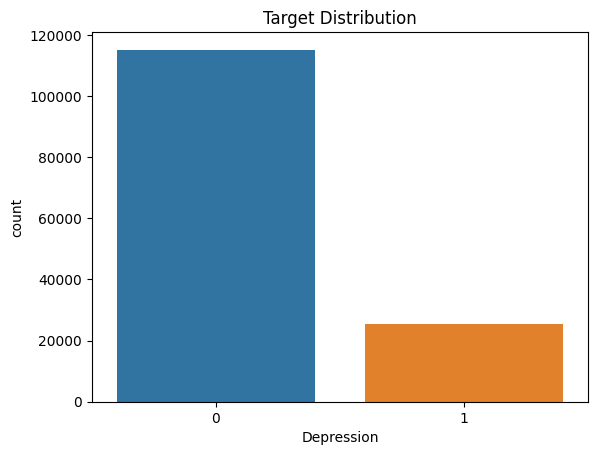

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic information
print(df_train.info())
print(df_train.describe())

# Check for null values
print(df_train.isnull().sum())

# Visualize target distribution
sns.countplot(data=df_train, x='Depression')
plt.title("Target Distribution")
plt.show()

In [30]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df_train.drop('Depression', axis=1) 
y = df_train['Depression']

# Split data into train and test sets 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()

#For the scaling
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_val_scaled=scaler.transform(X_val)

df_test_scaled=scaler.transform(df_test)

# Models Training 

In [32]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

In [34]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# Objective function for Optuna
def objective(trial):
    # Define the parameter space
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 1, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 15.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'verbose': 0
    }
    
    # Initialize CatBoostClassifier with class weights
    model = CatBoostClassifier(
        **params,
        eval_metric='Logloss',
        random_state=42
    )

    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in skf.split(X_train_scaled, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Train the model
        model.fit(X_train_fold, y_train_fold)
        # Predict on the validation fold
        y_pred = model.predict(X_val_fold)
        # Compute accuracy and append to scores
        scores.append(accuracy_score(y_val_fold, y_pred))
    
    # Return the mean accuracy across folds
    return np.mean(scores)


In [35]:
import os
import pickle

if not os.path.exists('best_params.pkl'):
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=20) 

  print("Best Hyperparameters:", study.best_params)
  print("Best Accuracy:", study.best_value)

  best_params = study.best_params
else:
  with open('best_params.pkl', 'rb') as file:
    best_params = pickle.load(file)


[I 2024-11-30 00:24:25,815] A new study created in memory with name: no-name-33af2f0c-e9a7-474c-9d7d-44cc0f4657c8
[I 2024-11-30 00:24:57,131] Trial 0 finished with value: 0.9373756218905471 and parameters: {'iterations': 352, 'depth': 5, 'learning_rate': 0.0550180043886203, 'l2_leaf_reg': 0.13605035463456383, 'border_count': 172, 'random_strength': 5.444965787119707, 'bagging_temperature': 0.49951065314436494}. Best is trial 0 with value: 0.9373756218905471.
[I 2024-11-30 00:26:00,177] Trial 1 finished with value: 0.9368425728500356 and parameters: {'iterations': 623, 'depth': 6, 'learning_rate': 0.07983664940075087, 'l2_leaf_reg': 1.0619988333454948, 'border_count': 228, 'random_strength': 8.386845748005973, 'bagging_temperature': 0.1733649826559498}. Best is trial 0 with value: 0.9373756218905471.
[I 2024-11-30 00:26:13,428] Trial 2 finished with value: 0.9370824449182658 and parameters: {'iterations': 137, 'depth': 5, 'learning_rate': 0.1869512498915185, 'l2_leaf_reg': 0.13869867640

Best Hyperparameters: {'iterations': 574, 'depth': 3, 'learning_rate': 0.1499844032338299, 'l2_leaf_reg': 13.650349307552684, 'border_count': 129, 'random_strength': 3.9517922497420903, 'bagging_temperature': 0.3206191160240667}
Best Accuracy: 0.9376421464108031


In [40]:
best_params = {'iterations': 574, 'depth': 3, 'learning_rate': 0.1499844032338299, 
               'l2_leaf_reg': 13.650349307552684, 'border_count': 129, 
               'random_strength': 3.9517922497420903,
               'bagging_temperature': 0.3206191160240667}

cat = CatBoostClassifier(**best_params, random_state=42, verbose=0)

cat.fit(X_train_scaled, y_train)


In [41]:
with open('best_params.pkl', 'wb') as file:
  pickle.dump(best_params, file)

In [43]:
y_pred = cat.predict(X_val_scaled)
test_accuracy = accuracy_score(y_val, y_pred)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9363539445628998


In [44]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
#bagging with gradident boost

bagging_cat = BaggingClassifier(cat,
                               n_estimators=400,
                               bootstrap=True,
                               random_state=42)

bagging_cat.fit(X_train_scaled, y_train)
y_pred = bagging_cat.predict(X_val_scaled)

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report:")
print(classification_report(y_val, y_pred))

Accuracy: 93.67%
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23027
           1       0.84      0.80      0.82      5113

    accuracy                           0.94     28140
   macro avg       0.90      0.88      0.89     28140
weighted avg       0.94      0.94      0.94     28140



In [45]:
import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import os
import pickle

def objective(trial):
    # Define XGBoost hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42,
        'use_label_encoder': False
    }

    model = xgb.XGBClassifier(**params)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    # Ensure compatibility with NumPy indexing
    X_train_array = X_train_scaled.to_numpy() if hasattr(X_train_scaled, 'to_numpy') else X_train_scaled
    y_train_array = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else y_train

    for train_idx, val_idx in skf.split(X_train_array, y_train_array):
        X_train_fold, X_val_fold = X_train_array[train_idx], X_train_array[val_idx]
        y_train_fold, y_val_fold = y_train_array[train_idx], y_train_array[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        scores.append(accuracy_score(y_val_fold, y_pred))

    return np.mean(scores)



In [46]:

# Save or load best parameters
if not os.path.exists('xgboost_best_params.pkl'):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    
    print("Best Hyperparameters:", study.best_params)
    print("Best Accuracy:", study.best_value)
    
    best_params = study.best_params
    with open('xgboost_best_params.pkl', 'wb') as file:
        pickle.dump(best_params, file)
else:
    with open('xgboost_best_params.pkl', 'rb') as file:
        best_params = pickle.load(file)


[I 2024-11-30 01:45:04,327] A new study created in memory with name: no-name-2a99b99b-e93b-4b66-adf9-e07690775093
[I 2024-11-30 01:45:18,217] Trial 0 finished with value: 0.9358653162757641 and parameters: {'n_estimators': 356, 'max_depth': 5, 'learning_rate': 0.13738104777758592, 'gamma': 1.304682346985084, 'min_child_weight': 1.3082779641313356, 'subsample': 0.5602824768094532, 'colsample_bytree': 0.7363287088392823, 'reg_alpha': 1.7417530491273014, 'reg_lambda': 3.900574395962637}. Best is trial 0 with value: 0.9358653162757641.
[I 2024-11-30 01:45:40,522] Trial 1 finished with value: 0.9366204690831555 and parameters: {'n_estimators': 637, 'max_depth': 7, 'learning_rate': 0.08436482170271233, 'gamma': 1.2753837892452358, 'min_child_weight': 7.575729836012538, 'subsample': 0.7697585102374053, 'colsample_bytree': 0.7470089031892613, 'reg_alpha': 4.395068996297876, 'reg_lambda': 0.020143476751764977}. Best is trial 1 with value: 0.9366204690831555.
[I 2024-11-30 01:45:53,050] Trial 2 

Best Hyperparameters: {'n_estimators': 881, 'max_depth': 4, 'learning_rate': 0.20725596606040336, 'gamma': 2.53570237618894, 'min_child_weight': 7.350044286906883, 'subsample': 0.7112249469544936, 'colsample_bytree': 0.5006200335146281, 'reg_alpha': 5.926463814388255, 'reg_lambda': 1.6659456997368984}
Best Accuracy: 0.9375533049040513


In [47]:

# Train final model with best hyperparameters
xgb_model = xgb.XGBClassifier(**best_params, random_state=42, use_label_encoder=False)
xgb_model.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred = xgb_model.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)
print("Final Accuracy on Test Set: {:.2f}%".format(accuracy * 100))

Final Accuracy on Test Set: 93.58%


In [48]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
#bagging with gradident boost

bagging_xgb = BaggingClassifier(xgb_model,
                               n_estimators=400,
                               # max_samples=0.6,
                               # max_features=0.8,
                               bootstrap=True,
                               random_state=42)

bagging_xgb.fit(X_train_scaled, y_train)
y_pred = bagging_xgb.predict(X_val_scaled)

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report:")
print(classification_report(y_val, y_pred))

Accuracy: 93.60%
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23027
           1       0.84      0.80      0.82      5113

    accuracy                           0.94     28140
   macro avg       0.90      0.88      0.89     28140
weighted avg       0.94      0.94      0.94     28140



In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the base classifiers for the VotingClassifier
clf3 = cat            # CatBoost model
clf4 = xgb_model      # XGBoost model
clf5 = bagging_cat    # Bagging with CatBoost
clf6 = bagging_xgb    # Bagging with XGBoost

# Initialize the VotingClassifier with the defined models
voting_classifier = VotingClassifier(
    estimators=[
        ('cat', clf3),      # CatBoost model
        ('xgb', clf4),      # XGBoost model
        ('bg_cat2', clf5),  # Bagging with CatBoost
        ('bg_xgb', clf6),   # Bagging with XGBoost
      
    ],
    voting='soft'
)

# Fit the VotingClassifier on the training data
voting_classifier.fit(X_train_scaled, y_train)

# Predict on the validation data
y_pred = voting_classifier.predict(X_val_scaled)

# Calculate and print the accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Print the classification report for detailed performance metrics
print("Classification Report:")
print(classification_report(y_val, y_pred))

In [51]:
df_test_sub = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')

In [52]:
y_test_pred = voting_classifier.predict(df_test_scaled)

# Create a submission file
submission_votting = pd.DataFrame({'id': df_test_sub['id'], 'Depression': y_test_pred})
submission_votting.to_csv('votting_submission.csv', index=False)

print('Submission file has been saved as "submission.csv"')

Submission file has been saved as "submission.csv"
